# Import everyting here

In [1]:
import torch.utils.data
import matplotlib.pyplot as plt
import torch
import scipy.integrate
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger


from Euler import *
from task_1 import *

%reload_ext autoreload
%autoreload 2

/home/gergedan/.local/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Setup Tensorboard

In [3]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6006

In [4]:
# train_dataset[0] --> trajectory sets as dict
# train_dataset[0]["traj"] --> first trajectory set 
# train_dataset[0]["traj_shifted"] --> first trajectory set shifted by one (targets)
train_dataset = None # 100x10x2
validation_dataset = None
test_dataset = None

# Create dataset

In [5]:
# Define the parameters
alpha = -1.8
(range_start, range_end) = (-2, 2)
(t_start, t_end, delta_t) = (0, 1, 0.01)
num_trajectories = 1000

evaluation_times = np.arange(t_start, t_end, delta_t)
print("will solve for times:", evaluation_times)

sols = generate_dataset(alpha, delta_t, range_start, range_end, t_start, t_end, num_trajectories)

print("Result have the shape:", sols.shape)


print("first datapoint in the first trajectory: ", sols[0][0][0], sols[0][1][0])
print("last datapoint in the first trajectory: ", sols[0][0][-1], sols[0][1][-1])



print("first datapoint in the last trajectory: ", sols[-1][0][0], sols[-1][1][0])
print("last datapoint in the last trajectory: ", sols[-1][0][-1], sols[-1][1][-1])



will solve for times: [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99]
Result have the shape: (1000, 2, 100)
first datapoint in the first trajectory:  0.017144998885464648 -0.1931369760107008
last datapoint in the first trajectory:  0.02846596052664596 -0.01525705019558592
first datapoint in the last trajectory:  -0.1573167653115761 0.051465194849850945
last datapoint in the last trajectory:  -0.021579613452585345 -0.017249118041166755


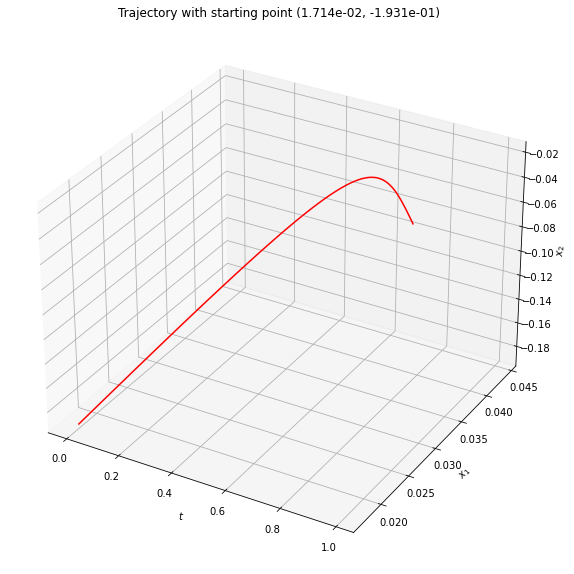

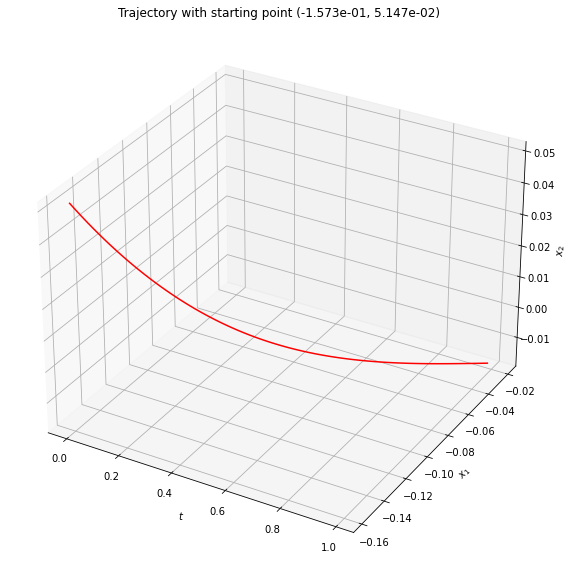

In [6]:
# Lets plot the first and last generated trajectories with different starting points
# to get a feeling how the data looks like 
plot_trajectory(sols[0], t_start, t_end, delta_t)
plot_trajectory(sols[999], t_start, t_end, delta_t)

# Prepare the dataset

In [7]:
# for training we want to have a shape (num_trajectories * num_datapoints, 2, 2)
# where we will hold values and corresponding targets in the second axis
train_dataset = reshape_for_training(sols)

print("train_dataset shape: ", train_dataset.shape)

train_dataset shape:  (99000, 2, 2)


In [7]:
"""
train_dataset = np.stack((train_dataset_values, train_dataset_targets))
print("train_dataset shape: ", train_dataset.shape)

train_dataset = np.moveaxis(train_dataset, 0, 1)
print("train_dataset shape: ", train_dataset.shape)

# As one can see, we could successfully generate the targets!
#print(train_dataset_values[0, :, :10])
#print(train_dataset_targets[0, :, :10])


#values_x = train_dataset_values[:, 0, :]
#values_y = train_dataset_values[:, 1, :]

#A = np.reshape(train_dataset_values, (1000, 9999, 2))
#print(A[0, :10, :])

#train_dataset_targets =

#(1000, 10000, 10000)

#((10000000, 2), (10000000, 2))
"""

'\ntrain_dataset = np.stack((train_dataset_values, train_dataset_targets))\nprint("train_dataset shape: ", train_dataset.shape)\n\ntrain_dataset = np.moveaxis(train_dataset, 0, 1)\nprint("train_dataset shape: ", train_dataset.shape)\n\n# As one can see, we could successfully generate the targets!\n#print(train_dataset_values[0, :, :10])\n#print(train_dataset_targets[0, :, :10])\n\n\n#values_x = train_dataset_values[:, 0, :]\n#values_y = train_dataset_values[:, 1, :]\n\n#A = np.reshape(train_dataset_values, (1000, 9999, 2))\n#print(A[0, :10, :])\n\n#train_dataset_targets =\n\n#(1000, 10000, 10000)\n\n#((10000000, 2), (10000000, 2))\n'

# Define hyperparameters

In [8]:
hparams = {
    "hidden_layer_1": 512,
    "hidden_layer_2": 512,
    "hidden_layer_3": 512,
    "delta_t": delta_t,
    "batch_size": 256,
    "learning_rate": 1e-3,
    "num_workers": 8,
}

In [9]:
model = Euler(hparams)

# Validation set

VAL DATASET SHAPE: (200, 2, 1000)
VAL DATASET SHAPE: (199800, 2, 2)
Score of the Model before training: 19593.489855007378
FIRST VALUE:  -1.6398866338717073 tensor(-1.6563, dtype=torch.float64)
LAST VALUE:  -1.9032087963019264 tensor(-1.9222, dtype=torch.float64)


/tmp/ipykernel_17059/1603228050.py:70: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(trajectory)
/tmp/ipykernel_17059/1603228050.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(trajectory)


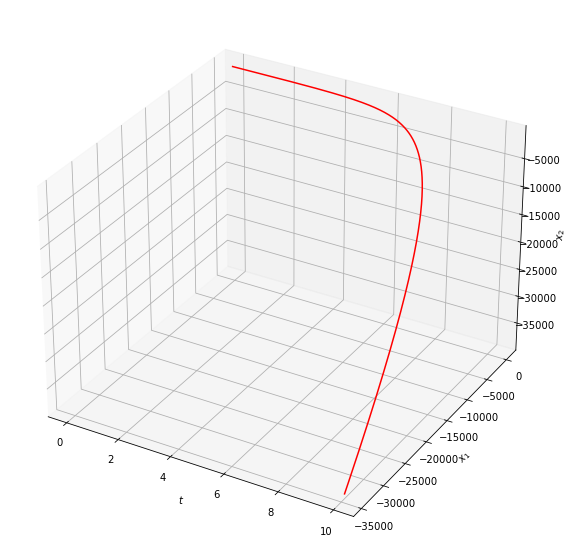

In [10]:
start_positions = np.random.uniform(-2, 2, (200, 2))

sols = []
t_eval = np.arange(0, 10, delta_t)

for start_position in start_positions:
    sol = scipy.integrate.solve_ivp(lambda t, y: get_derivatives(y[0], y[1], alpha), (0, 10) , start_position, t_eval=t_eval)
    sols.append(sol.y)
    
validation_dataset_values = np.array(sols)

print("VAL DATASET SHAPE:", validation_dataset_values.shape)

validation_dataset_targets = np.delete(validation_dataset_values, (0), axis=-1)
validation_dataset_values = np.delete(validation_dataset_values, (-1), axis=-1)

validation_dataset_values = np.moveaxis(validation_dataset_values, 1, -1).reshape((validation_dataset_values.shape[0] * validation_dataset_values.shape[2], 2))

validation_dataset_targets = np.moveaxis(validation_dataset_targets, 1, -1).reshape((validation_dataset_targets.shape[0] * validation_dataset_targets.shape[2], 2))


validation_dataset = np.stack((validation_dataset_values, validation_dataset_targets))

validation_dataset = np.moveaxis(validation_dataset , 0, 1)


print("VAL DATASET SHAPE:", validation_dataset.shape)

def evaluate_model(model, dataset):
    """
    TODO
    """
    model.eval()
    model.to(device)
    criterion = torch.nn.MSELoss()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=hparams["batch_size"], shuffle=False)
    loss = 0
    for batch in dataloader:
        pos = batch[:, 0]
        pos_target = batch[:, 1]
        
        pos = pos.to(device)
        pos_target = pos_target.to(device)
        
        #x = torch.flatten(traj).to(device)
        #y = torch.flatten(traj_shifted).to(device)
        
        pred = model.forward(pos.float()).to(device)
        
        loss += criterion(pred.float(), pos_target.float()).item()
    return 1.0 / (2 * (loss/len(dataloader)))


def recreate_trajectory(model, start_position, t_start, t_end, delta_t):
    """
    TODO
    """
    trajectory = [start_position]
    last_traj = torch.tensor(start_position)
    
    last_traj = last_traj.to(device)
    
    t0 = t_start
    while t0 < t_end - delta_t:
        last_traj = last_traj + delta_t * model(last_traj.float())
        trajectory.append(last_traj.cpu().detach())
        
        t0 += delta_t
        
    return np.array(trajectory)


print("Score of the Model before training:", evaluate_model(model, validation_dataset))

# plot the first one
recreation = recreate_trajectory(model, start_positions[0], t_eval[0], t_eval[-1], delta_t)

# unzip the list 
recreation = [[i for i, j in recreation],
                 [j for i, j in recreation]]

fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, recreation[0], recreation[1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_xlabel(r"$t$")
ax0.set_ylabel(r"$x_1$")
ax0.set_zlabel(r"$x_2$")


print("FIRST VALUE: ", recreation[0][0], recreation[0][1])
print("LAST VALUE: ", recreation[-1][0], recreation[-1][1])


In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                         shuffle=False,
                                         batch_size=hparams["batch_size"],
                                         num_workers=8)
validation__dataloader = torch.utils.data.DataLoader(validation_dataset,
                                         shuffle=False,
                                         batch_size=hparams["batch_size"],
                                         num_workers=8)

In [12]:
trainer = pl.Trainer(
    max_epochs=5,
    log_every_n_steps=1,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 527 K 
-------------------------------------
527 K     Trainable params
0         Non-trainable params
527 K     Total params
2.111     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Score of the Model after training: 11084461.778711867


/tmp/ipykernel_17059/1603228050.py:70: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(trajectory)
/tmp/ipykernel_17059/1603228050.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(trajectory)


FIRST VALUE:  -1.6398866338717073 tensor(-1.6549, dtype=torch.float64)
LAST VALUE:  -1.9032087963019264 tensor(-1.9210, dtype=torch.float64)
FIRST VALUE:  1.0472431378491773 tensor(1.0573, dtype=torch.float64)
LAST VALUE:  0.5401996548094234 tensor(0.5455, dtype=torch.float64)


/tmp/ipykernel_17059/1603228050.py:70: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array(trajectory)
/tmp/ipykernel_17059/1603228050.py:70: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(trajectory)


Text(0.5, 0, '$x_2$')

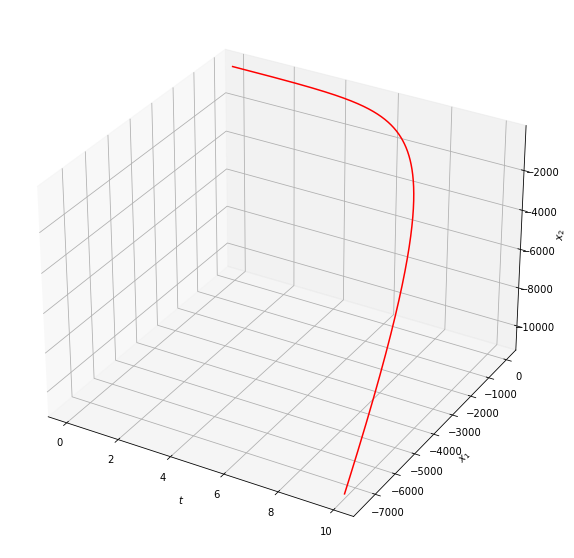

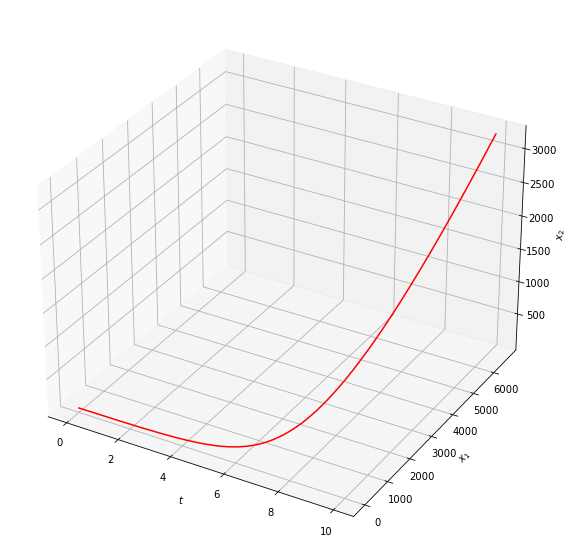

In [13]:
print("Score of the Model after training:", evaluate_model(model, validation_dataset))

# plot the first one
recreation = recreate_trajectory(model, start_positions[0], t_eval[0], t_eval[-1], delta_t)

# unzip the list 
recreation = [[i for i, j in recreation],
                 [j for i, j in recreation]]

print("FIRST VALUE: ", recreation[0][0], recreation[0][1])
print("LAST VALUE: ", recreation[-1][0], recreation[-1][1])

fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, recreation[0], recreation[1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_xlabel(r"$t$")
ax0.set_ylabel(r"$x_1$")
ax0.set_zlabel(r"$x_2$")

# plot the last one
recreation = recreate_trajectory(model, start_positions[-1], t_eval[0], t_eval[-1], delta_t)

# unzip the list 
recreation = [[i for i, j in recreation],
                 [j for i, j in recreation]]

print("FIRST VALUE: ", recreation[0][0], recreation[0][1])
print("LAST VALUE: ", recreation[-1][0], recreation[-1][1])

fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, recreation[0], recreation[1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_xlabel(r"$t$")
ax0.set_ylabel(r"$x_1$")
ax0.set_zlabel(r"$x_2$")